In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
df = pd.read_excel("data/Telco_customer_churn_adapted_v2.xlsx")
columns = ["Tenure Months", "Monthly Purchase (Thou. IDR)", "CLTV (Predicted Thou. IDR)"]
X = df.copy()[columns]

churners = X.loc[df[df["Churn Label"] == "Yes"].index]
non_churners = X.loc[df[df["Churn Label"] == "No"].index]

# Value-based Segmentation

In [49]:
def visualize_value_based_clustering(data, k=3):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto")
    kmeans.fit(data_scaled)

    data["Cluster"] = kmeans.labels_

    fig, axes = plt.subplots(1, len(data.columns)-1, figsize=(16, 5))

    for i, column in enumerate(data.columns[:-1]):
        sns.boxplot(ax=axes[i], data=data, x='Cluster', y=column)
        axes[i].set_title(column)

    fig.tight_layout()

    return fig

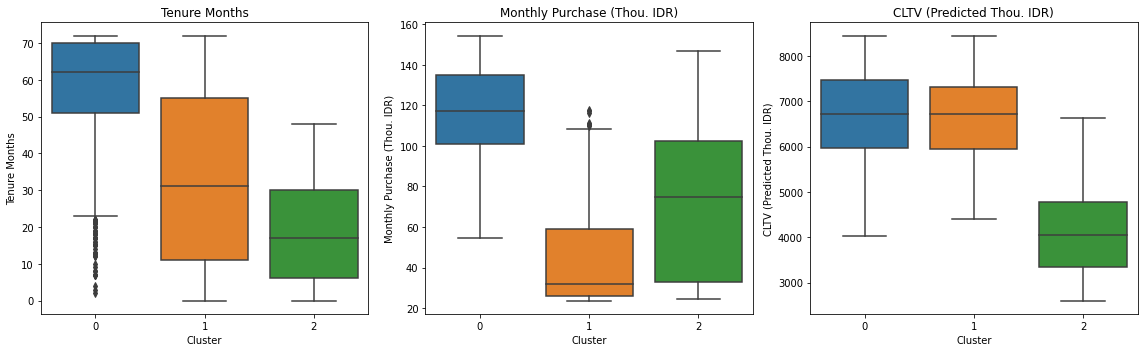

In [51]:
resulting_figure = visualize_value_based_clustering(non_churners, k=3)
plt.show()

# Needs-based Segmentation

In [6]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [53]:
df = pd.read_excel("data/Telco_customer_churn_adapted_v2.xlsx")
columns = ['Games Product', 'Music Product', 'Education Product', 'Video Product']
X = df.copy()[columns]

churners = X.loc[df[df["Churn Label"] == "Yes"].index]
non_churners = X.loc[df[df["Churn Label"] == "No"].index]

### Churners

In [54]:
churners = X.loc[df[df["Churn Label"] == "Yes"].index]
churners = churners[churners["Video Product"] != 'No internet service']
for col in columns:
    # print(col)
    # print(churners[col].unique())
    # print()

    churners[col] = churners[col].replace({"Yes": 1, "No":0})

scaler = StandardScaler()
churners_scaled = scaler.fit_transform(churners)

k=2
kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto")
kmeans.fit(churners_scaled)

result = churners.copy()
result["label"] = kmeans.labels_

for col in columns:
    result[col] = result[col].replace({1: "Yes", 0: "No"})

Processing 4 combinations | Sampling itemset size 43


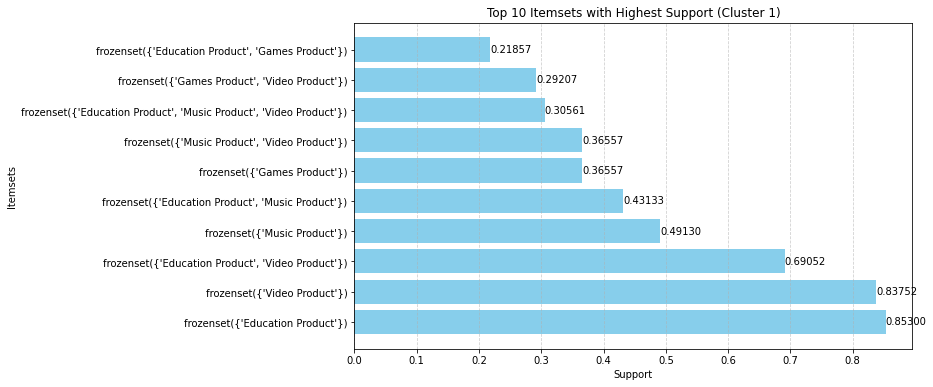

In [59]:
def visualize_apriori_results(cluster_label, num_top_itemsets=5):
    cluster_data = result[result["label"] == cluster_label].drop("label", axis=1).reset_index(drop=True)

    transactions = []
    for i in range(len(cluster_data)):
        x = cluster_data.iloc[i]
        product_used = [product_name for product_name, usage in zip(x.index, x) if usage == "Yes"]
        transactions.append(product_used)

    encoder = TransactionEncoder()
    one_hot = encoder.fit(transactions).transform(transactions)
    one_hot_df = pd.DataFrame(one_hot, columns=encoder.columns_)

    apriori_result = apriori(one_hot_df, min_support=1e-5, use_colnames=True, verbose=1)

    # Sort Apriori results by support in descending order
    apriori_result = apriori_result.sort_values(by='support', ascending=False).reset_index(drop=True)

    # Select the top itemsets
    top_itemsets = apriori_result.head(num_top_itemsets)

    # Plotting the horizontal bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_itemsets['itemsets'].astype(str), top_itemsets['support'], color='skyblue')
    plt.xlabel('Support')
    plt.ylabel('Itemsets')
    plt.title(f'Top {num_top_itemsets} Itemsets with Highest Support (Cluster {cluster_label})')
    plt.grid(axis='x', linestyle='--', alpha=0.6)

    # Display the support values on the bars
    for index, value in enumerate(top_itemsets['support']):
        plt.text(value, index, f'{value:.5f}', va='center')

    plt.show()

# Example: Visualize top 5 itemsets for Cluster 0
visualize_apriori_results(cluster_label=1, num_top_itemsets=10)

### Non-churners

In [39]:
non_churners = non_churners[non_churners["Video Product"] != 'No internet service']
for col in columns:
    non_churners[col] = non_churners[col].replace({"Yes": 1, "No":0})

scaler = StandardScaler()
non_churners_scaled = scaler.fit_transform(non_churners)

k=3
kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto")
kmeans.fit(non_churners_scaled)

result = non_churners.copy()
result["label"] = kmeans.labels_

for col in columns:
    result[col] = result[col].replace({1: "Yes", 0: "No"})

Processing 12 combinations | Sampling itemset size 2


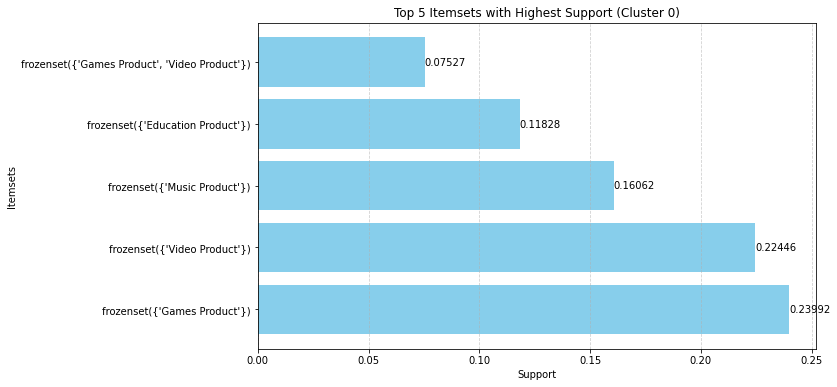

In [40]:
visualize_apriori_results(cluster_label=0, num_top_itemsets=5)

In [60]:
def visualize_needs_based_clustering(data, k=2, num_top_itemsets=5):
    # Preprocess the data
    for col in data.columns:
        data[col] = data[col].replace({"Yes": 1, "No": 0})

    # Standardize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto")
    kmeans.fit(data_scaled)

    # Add cluster labels to the data
    result = data.copy()
    result["label"] = kmeans.labels_

    for col in data.columns:
        result[col] = result[col].replace({1: "Yes", 0: "No"})

    # Visualize Apriori results for each cluster
    fig_list = []
    for cluster_label in range(k):
        cluster_data = result[result["label"] == cluster_label].drop("label", axis=1).reset_index(drop=True)

        transactions = []
        for i in range(len(cluster_data)):
            x = cluster_data.iloc[i]
            product_used = [product_name for product_name, usage in zip(x.index, x) if usage == "Yes"]
            transactions.append(product_used)

        encoder = TransactionEncoder()
        one_hot = encoder.fit(transactions).transform(transactions)
        one_hot_df = pd.DataFrame(one_hot, columns=encoder.columns_)

        apriori_result = apriori(one_hot_df, min_support=1e-5, use_colnames=True, verbose=1)

        # Sort Apriori results by support in descending order
        apriori_result = apriori_result.sort_values(by='support', ascending=False).reset_index(drop=True)

        # Select the top itemsets
        top_itemsets = apriori_result.head(num_top_itemsets)

        # Plotting the horizontal bar chart
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.barh(top_itemsets['itemsets'].astype(str), top_itemsets['support'], color='skyblue')
        ax.set_xlabel('Support')
        ax.set_ylabel('Itemsets')
        ax.set_title(f'Top {num_top_itemsets} Itemsets with Highest Support (Cluster {cluster_label})')
        ax.grid(axis='x', linestyle='--', alpha=0.6)

        # Display the support values on the bars
        for index, value in enumerate(top_itemsets['support']):
            ax.text(value, index, f'{value:.5f}', va='center')

        fig_list.append(fig)

    return fig_list

Processing 3 combinations | Sampling itemset size 32
Processing 4 combinations | Sampling itemset size 43


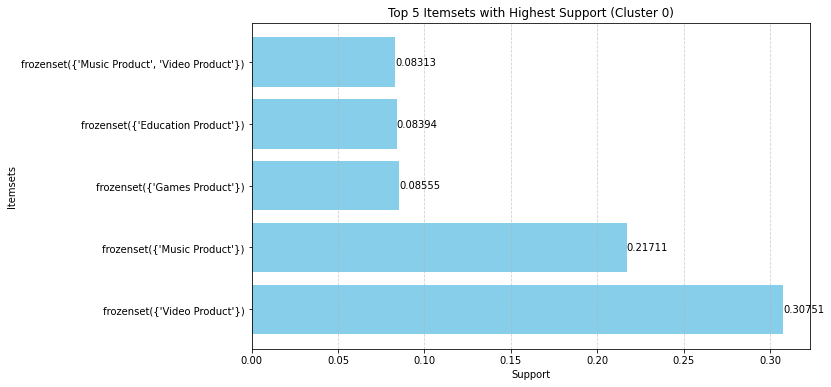

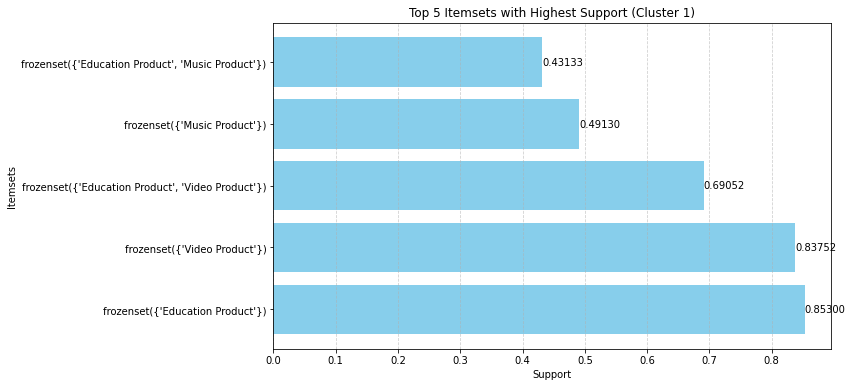

In [64]:
# Example: Visualize top 5 itemsets for Cluster 0
# Gantilah 'churners' dengan data sesuai kebutuhan
# Gantilah 'k' dan 'num_top_itemsets' dengan nilai yang diinginkan
resulting_figures = visualize_needs_based_clustering(churners, k=2, num_top_itemsets=5)

# Menampilkan visualisasi jika diinginkan
for fig in resulting_figures:
    plt.show()

In [65]:
churners

,Games Product,Music Product,Education Product,Video Product
0,1,1,0,0
1,0,0,0,0
2,0,0,1,1
3,0,0,1,1
4,0,1,1,1
...,...,...,...,...
1864,0,0,0,1
1865,0,0,0,0
1866,0,0,0,0
1867,1,1,1,1
